In [17]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt


In [18]:
df = pd.read_csv("data_zillow.csv")

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Columns: 312 entries, RegionID to 2025-07-31
dtypes: float64(307), int64(2), object(3)
memory usage: 2.1+ MB


In [20]:
print(df.head(5))

   RegionID  SizeRank       RegionName RegionType StateName     2000-01-31  \
0    102001         0    United States    country       NaN  124908.647735   
1    394913         1     New York, NY        msa        NY  223585.344443   
2    753899         2  Los Angeles, CA        msa        CA  225639.777055   
3    394463         3      Chicago, IL        msa        IL  159124.374736   
4    394514         4       Dallas, TX        msa        TX  129889.939824   

      2000-02-29     2000-03-31     2000-04-30     2000-05-31  ...  \
0  125128.402089  125400.929845  125985.448387  126658.159150  ...   
1  224535.456006  225494.367314  227437.492677  229449.666280  ...   
2  226479.443314  227597.870765  229823.165684  232256.940692  ...   
3  159271.677552  159552.218361  160250.134174  161089.642950  ...   
4  129947.793257  130014.301701  130187.017143  130414.737725  ...   

      2024-10-31     2024-11-30     2024-12-31     2025-01-31     2025-02-28  \
0  368814.621647  369318.59645

In [21]:
df_long = df.melt(
    id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"], 
    var_name="Date", 
    value_name="Value"
)

# Convert Date to datetime
df_long["Date"] = pd.to_datetime(df_long["Date"], errors="coerce")

# Drop rows where Value is missing (optional, but common in Zillow data)
df_long = df_long.dropna(subset=["Value"])

# Preview
print(df_long.head(10))

   RegionID  SizeRank        RegionName RegionType StateName       Date  \
0    102001         0     United States    country       NaN 2000-01-31   
1    394913         1      New York, NY        msa        NY 2000-01-31   
2    753899         2   Los Angeles, CA        msa        CA 2000-01-31   
3    394463         3       Chicago, IL        msa        IL 2000-01-31   
4    394514         4        Dallas, TX        msa        TX 2000-01-31   
5    394692         5       Houston, TX        msa        TX 2000-01-31   
6    395209         6    Washington, DC        msa        VA 2000-01-31   
7    394974         7  Philadelphia, PA        msa        PA 2000-01-31   
8    394856         8         Miami, FL        msa        FL 2000-01-31   
9    394347         9       Atlanta, GA        msa        GA 2000-01-31   

           Value  
0  124908.647735  
1  223585.344443  
2  225639.777055  
3  159124.374736  
4  129889.939824  
5  125748.782522  
6  184643.822315  
7  125541.539940  
8  

In [22]:
# # Sort by region and date
# df_long = df_long.sort_values(["RegionName", "Date"])

# # Create lag features, e.g., previous month value
# df_long["Value_lag1"] = df_long.groupby("RegionName")["Value"].shift(1)
# df_long["Value_lag2"] = df_long.groupby("RegionName")["Value"].shift(2)
# df_long["Value_lag3"] = df_long.groupby("RegionName")["Value"].shift(3)

# # Drop rows with NaN (first 3 months per region)
# df_long = df_long.dropna()

In [23]:
# X = df_long[["Value_lag1", "Value_lag2", "Value_lag3"]]
# Y = df_long["Value"]

In [24]:
# Input=[('scale',StandardScaler()), ('model',LinearRegression())]
# pipe=Pipeline(Input)

In [25]:
# X.shape, Y.shape

In [26]:
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=33)
# pipe.fit(X_train, Y_train)
# Y_hat = pipe.predict(X_test)

In [27]:
# print(r2_score(Y_test, Y_hat))
# print(root_mean_squared_error(Y_test, Y_hat))

In [28]:
# sns.lineplot(x=Y_test, y=Y_hat)

In [29]:
print(len(df_long['RegionName'].unique()))
print((df_long['RegionName'].unique()))

895
['United States' 'New York, NY' 'Los Angeles, CA' 'Chicago, IL'
 'Dallas, TX' 'Houston, TX' 'Washington, DC' 'Philadelphia, PA'
 'Miami, FL' 'Atlanta, GA' 'Boston, MA' 'Phoenix, AZ' 'San Francisco, CA'
 'Riverside, CA' 'Detroit, MI' 'Seattle, WA' 'Minneapolis, MN'
 'San Diego, CA' 'Tampa, FL' 'Denver, CO' 'Baltimore, MD' 'St. Louis, MO'
 'Orlando, FL' 'Charlotte, NC' 'San Antonio, TX' 'Portland, OR'
 'Sacramento, CA' 'Pittsburgh, PA' 'Cincinnati, OH' 'Austin, TX'
 'Las Vegas, NV' 'Kansas City, MO' 'Columbus, OH' 'Cleveland, OH'
 'San Jose, CA' 'Nashville, TN' 'Virginia Beach, VA' 'Providence, RI'
 'Jacksonville, FL' 'Milwaukee, WI' 'Oklahoma City, OK' 'Raleigh, NC'
 'Memphis, TN' 'Richmond, VA' 'Louisville, KY' 'New Orleans, LA'
 'Salt Lake City, UT' 'Hartford, CT' 'Buffalo, NY' 'Birmingham, AL'
 'Rochester, NY' 'Grand Rapids, MI' 'Tucson, AZ' 'Urban Honolulu, HI'
 'Tulsa, OK' 'Fresno, CA' 'Worcester, MA' 'Omaha, NE' 'Bridgeport, CT'
 'Greenville, SC' 'Bakersfield, CA' 'Albany, NY'

In [41]:
# Filter for one region
def show_plots(region):
    # print(f"Showing plots for {region}")
    df_region = df_long[df_long["RegionName"] == region][["Date", "Value"]]

    df_agg = df_region.groupby("Date")["Value"].mean().reset_index()

    # Prophet expects columns named 'ds' (date) and 'y' (value)
    df_prophet = df_agg.rename(columns={"Date": "ds", "Value": "y"})

    # Initialize and fit model
    model = Prophet(
        yearly_seasonality=True,
        daily_seasonality=False,
        weekly_seasonality=False,
        changepoint_prior_scale=0.05
    )
    model.add_seasonality(name='monthly', period=12, fourier_order=5)
    model.fit(df_prophet)

    # Make future dataframe (24 months ahead)
    future = model.make_future_dataframe(periods=24, freq="M")

    # Forecast
    forecast = model.predict(future)
    # print(forecast.head(5))

    # Plot forecast
    fig1 = model.plot(forecast)
    plt.show()

    # Plot forecast components (trend + seasonality)
    fig2 = model.plot_components(forecast)
    plt.show()

    # Returning next 12 months forecast
    last_date = df_prophet["ds"].max()
    next_12 = forecast[forecast["ds"] > last_date].head(12)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

    return next_12, df_agg


18:45:40 - cmdstanpy - INFO - Chain [1] start processing
18:45:40 - cmdstanpy - INFO - Chain [1] done processing


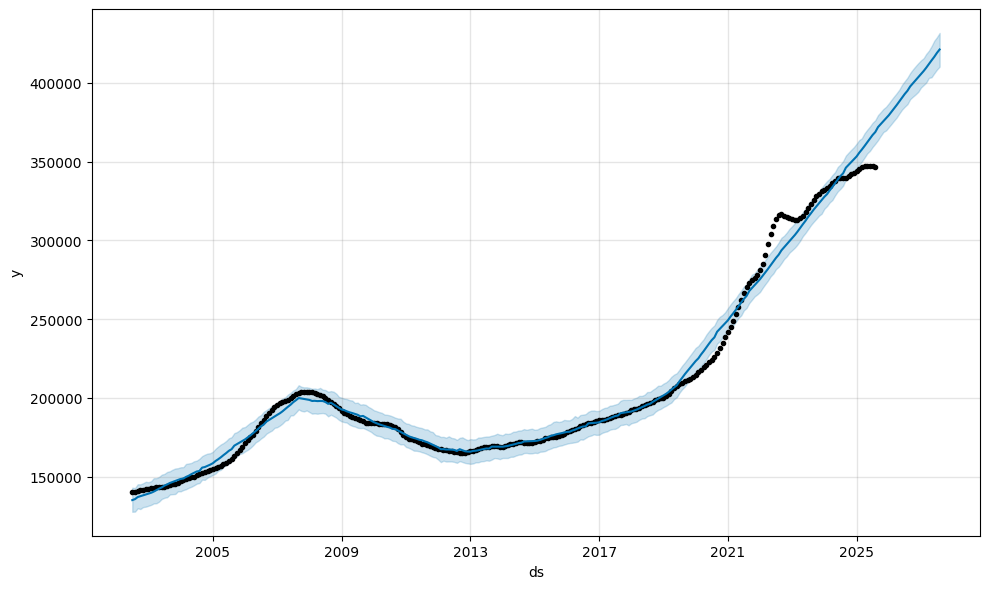

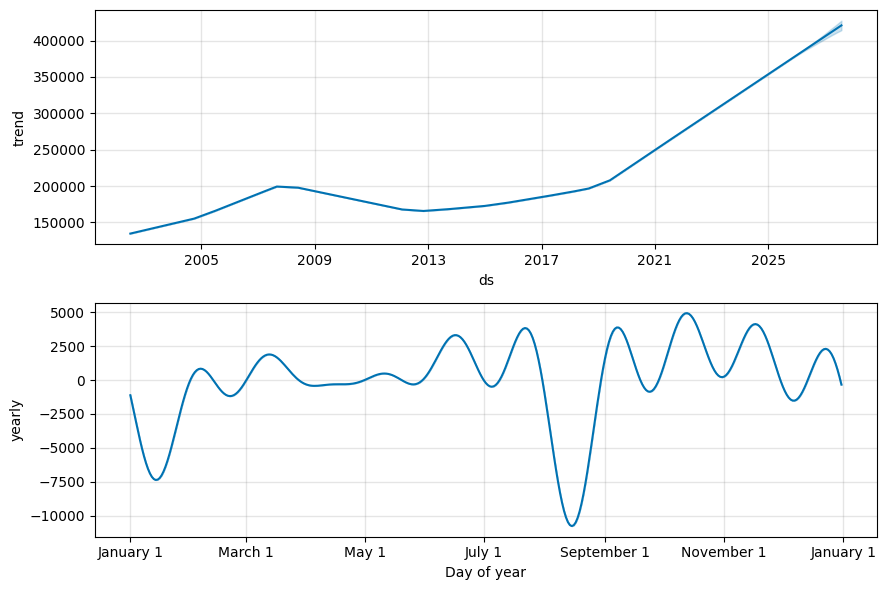

In [57]:
# region_input_value = input("Enter a region (e.g., 'New York, NY'): ")
# region_input_value = "New York, NY"
region_input_value = "Albuquerque, NM"
next_12_months, historical_df = show_plots(region_input_value)


In [58]:
df_zillow_forecast = pd.read_csv("Metro_zhvf_growth_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")
df_zillow_forecast.head(5)

,RegionID,SizeRank,RegionName,RegionType,StateName,BaseDate,2025-08-31,2025-10-31,2026-07-31
0,102001,0,United States,country,NaN,2025-07-31,0.0,0.2,0.4
1,394913,1,"New York, NY",msa,NY,2025-07-31,0.2,0.3,0.0
2,753899,2,"Los Angeles, CA",msa,CA,2025-07-31,-0.1,0.0,-0.1
3,394463,3,"Chicago, IL",msa,IL,2025-07-31,0.3,0.5,0.5
4,394514,4,"Dallas, TX",msa,TX,2025-07-31,-0.4,-1.0,-1.3


In [59]:
# Check this data with the Zillow forecast data
zillow_pred_long = df_zillow_forecast.melt(
    id_vars=["RegionID", "SizeRank", "RegionName", "RegionType", "StateName", "BaseDate"], 
    var_name="Date", 
    value_name="Value"
)

# Convert Date to datetime
zillow_pred_long["Date"] = pd.to_datetime(zillow_pred_long["Date"], errors="coerce")

# Preview
print(zillow_pred_long.head(5))


   RegionID  SizeRank       RegionName RegionType StateName    BaseDate  \
0    102001         0    United States    country       NaN  2025-07-31   
1    394913         1     New York, NY        msa        NY  2025-07-31   
2    753899         2  Los Angeles, CA        msa        CA  2025-07-31   
3    394463         3      Chicago, IL        msa        IL  2025-07-31   
4    394514         4       Dallas, TX        msa        TX  2025-07-31   

        Date  Value  
0 2025-08-31    0.0  
1 2025-08-31    0.2  
2 2025-08-31   -0.1  
3 2025-08-31    0.3  
4 2025-08-31   -0.4  


In [60]:
zillow_region = zillow_pred_long[zillow_pred_long["RegionName"] == region_input_value][["Date", "Value"]]

In [61]:
next_temp = next_12_months[next_12_months['ds'].isin(["2025-08-31","2025-10-31","2026-07-31"])].iloc[:,:2]
# next_temp['perc_change'] = (next_temp['yhat'] - ref_val) / ref_val
next_temp

,ds,yhat
278,2025-08-31,371891.194597
280,2025-10-31,375583.801881
289,2026-07-31,394938.936734


In [62]:
zillow_region

,Date,Value
61,2025-08-31,0.0
956,2025-10-31,0.3
1851,2026-07-31,1.8


In [64]:
# Step 1: Compute percent change from last known value
ref_val = historical_df['Value'].iloc[-1]
next_temp['perc_change'] = (next_temp['yhat'] - ref_val) / ref_val * 100

# Step 2: Align column names for merging
next_temp_renamed = next_temp.rename(columns={'ds': 'Date', 'yhat': 'Prophet_pred'})

# Step 3: Merge with Zillow values
merged = pd.merge(
    next_temp_renamed[['Date', 'Prophet_pred', 'perc_change']],
    zillow_region[['Date', 'Value']],
    on='Date',
    how='inner'
)


In [65]:
y_true = merged["Value"].values   # Zillow forecast (% change)
y_pred = merged["Prophet_pred"].values   # Prophet forecast (% change)

rmse = (root_mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

RMSE: 380938.03935159394
MAE: 380803.94440377556
R2: -234054499716.8008


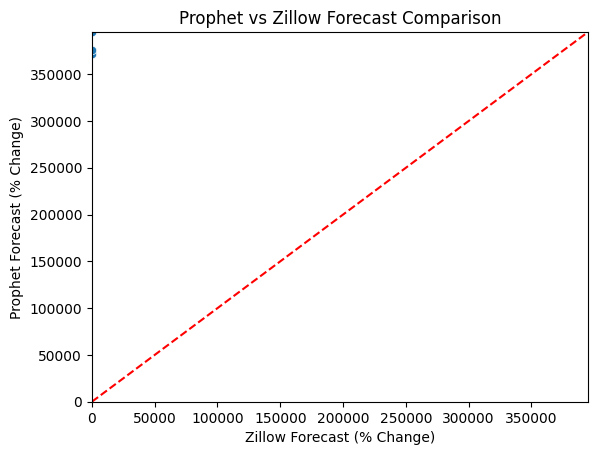

In [66]:
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel("Zillow Forecast (% Change)")
plt.ylabel("Prophet Forecast (% Change)")
plt.title("Prophet vs Zillow Forecast Comparison")
plt.axline((0,0), slope=1, color="red", linestyle="--")  # 45° line
plt.xlim(min(y_true.min(), y_pred.min()) - 1, max(y_true.max(), y_pred.max()) + 1)
plt.ylim(min(y_true.min(), y_pred.min()) - 1, max(y_true.max(), y_pred.max()) + 1)
plt.show()
